In [ ]:
import pandas as pd
import random
import re
from langchain_community.chat_models import ChatOllama
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
load_dotenv()


True

In [ ]:
samples_per_label_fewshot = 3
samples_per_labels_eval = 5

In [ ]:
llm = ChatOllama(model="gemma2:27b", base_url=os.environ["HOST"])


In [ ]:
df = pd.read_csv("../data/Supplementary data - responses and measures.csv", index_col=False)
random.seed(42)
df = df[~df['Response'].isna()]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['empathy_level'] = df['EmpathyQ_1'].apply(lambda x: 1 if x > 4 else 0)

In [ ]:
def format_example(row, empathy_col: str):
    return f"Response: {row['Response'].strip()}\nEmpathy score:{int(row[empathy_col])}"


In [ ]:
def create_few_shot_examples_and_eval_df(
    df: pd.DataFrame, empathy_col: str, n_samples_few_shot: int, n_samples_eval: int
) -> pd.DataFrame:
    """Create n_samples_few_shot examples for each label
    After that, creates an evaluation df. The evaluation df consists of n_samples_eval (without the few-shot examples)
    """
    few_shot_df = (
        df.groupby(empathy_col)
        .apply(lambda x: x.sample(n=n_samples_few_shot, random_state=42))
        .reset_index(drop=True)
    )
    # DO NOT eval on the examples from the few shot
    eval_df = (
        df.drop(few_shot_df.index)
        .groupby(empathy_col)
        .apply(lambda x: x.sample(n=n_samples_eval, random_state=42))
        .reset_index(drop=True)
    )
    few_shot_examples = "\n\n".join(
    few_shot_df.apply(lambda row: format_example(row, empathy_col=empathy_col), axis=1)
)
    return eval_df, few_shot_examples

In [ ]:
def run_few_shots(eval_df, system_prompt, few_shot_examples, empathy_col: str):
    """Run the llm with few-shot learning prompt - the llm predicts the given responses"""
    true_label = []
    predicted_label = []
    for i, row in eval_df.iterrows():
        response = row["Response"]
        prompt = system_prompt.format(few_shot_block=few_shot_examples, response=response)

        response = llm.invoke(prompt).content
        match = re.search(r"\b([0-9])\b", response)
        score = int(match.group(1)) if match else -1

        true_label.append(int(row[empathy_col]))
        predicted_label.append(score)
    valid_true_labels = [true_l for true_l, pred_l in zip(true_label, predicted_label) if pred_l != -1]
    valid_predictions = [pred_l for pred_l in predicted_label if pred_l != -1]
    return valid_true_labels, valid_predictions


In [9]:
def plot_conf_mat(true_labels, predicted_labels, title: str, n_labels: int):
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(n_labels)), normalize="true")
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=range(n_labels), yticklabels=range(n_labels))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Evaluate on all empathy levels

In [10]:
eval_df_all, few_shot_examples = create_few_shot_examples_and_eval_df(df=df, empathy_col='EmpathyQ_1', n_samples_few_shot=samples_per_label_fewshot, n_samples_eval=samples_per_labels_eval)


In [11]:
few_shots_prompt = """{few_shot_block}

Below is a chatbot response. Rate how empathetic it is, on a scale from 0 (not empathetic at all) to 9 (very empathetic and emotionally validating).

Return ONLY the empathy score (an integer between 0 and 9).

Response: {response}
Empathy score (0–9 only):"""

In [12]:
valid_true_labels, valid_predictions = run_few_shots(eval_df=eval_df_all, system_prompt=few_shots_prompt, few_shot_examples=few_shot_examples, empathy_col="EmpathyQ_1")
print(classification_report(valid_true_labels, valid_predictions, digits=3, zero_division=0.0))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000         5
           3      0.000     0.000     0.000         4
           4      0.000     0.000     0.000         5
           5      0.000     0.000     0.000         4
           6      0.000     0.000     0.000         5
           7      0.000     0.000     0.000         5
           8      0.000     0.000     0.000         5
           9      0.105     0.800     0.186         5

    accuracy                          0.085        47
   macro avg      0.011     0.080     0.019        47
weighted avg      0.011     0.085     0.020        47



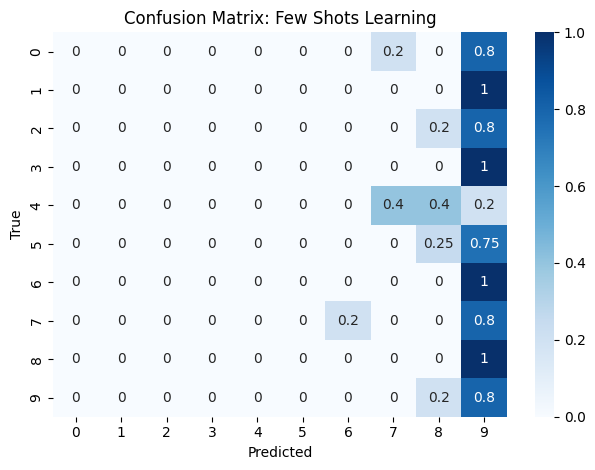

In [13]:
plot_conf_mat(true_labels=valid_true_labels, predicted_labels=valid_predictions, title="Confusion Matrix: Few Shots Learning", n_labels=10)

## Binary evaluation

In [14]:
few_shots_binary_score_prompt = """{few_shot_block}

Below is a chatbot response. Rate how empathetic it is, on a scale from 0 (not empathetic at all) to 1 (very empathetic and emotionally validating).

Return ONLY the empathy score (an integer between 0 and 1).

Response: {response}
Empathy score (0–1 only):"""

              precision    recall  f1-score   support

           0      0.571     0.160     0.250        25
           1      0.512     0.880     0.647        25

    accuracy                          0.520        50
   macro avg      0.542     0.520     0.449        50
weighted avg      0.542     0.520     0.449        50



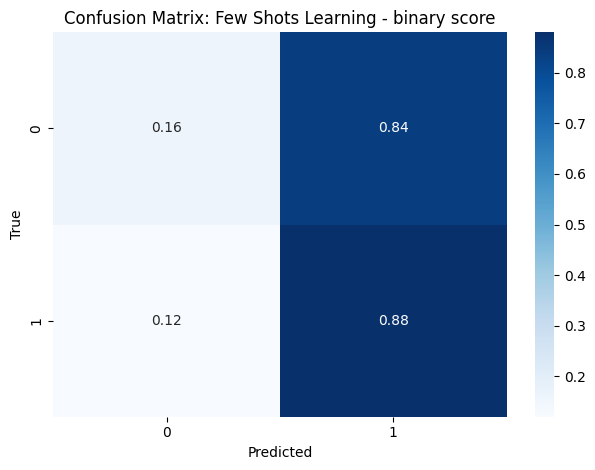

In [23]:
eval_df_binary, few_shot_examples_binary = create_few_shot_examples_and_eval_df(df=df, empathy_col='empathy_level', n_samples_few_shot=10, n_samples_eval=25)

valid_true_labels_binary, valid_predictions_binary = run_few_shots(eval_df=eval_df_binary, system_prompt=few_shots_binary_score_prompt, few_shot_examples=few_shot_examples_binary, empathy_col="empathy_level")
print(classification_report(valid_true_labels_binary, valid_predictions_binary, digits=3, zero_division=0.0))
plot_conf_mat(true_labels=valid_true_labels_binary, predicted_labels=valid_predictions_binary, title="Confusion Matrix: Few Shots Learning - binary score", n_labels=2)